# I. Gaussian Process 
@author: BAIM Mohamed Jalal

In [16]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

## Data 
- input.data is a  34x2 matrix corresponds to a 2D data point (Xi, Yi)

- Yi = f(Xi) + eps_i while eps_i is a N(0,inv_beta), and beta = 5 

In [17]:
def load_data(filepath):
    with open(filepath, 'r') as f:
        data = np.loadtxt(f, delimiter=' ')
    
    X, Y = data[:, 0], data[:, 1]
    return X, Y

filepath = '../data/input.data'
X, Y = load_data(filepath)
print(X.shape, Y.shape)

(34,) (34,)


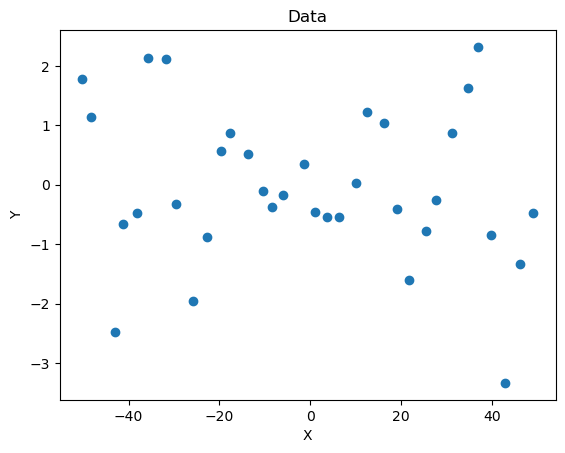

In [18]:
# visualizing the data
plt.scatter(X, Y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data')
plt.show()

## Task 1
- GP Regression to predict f 
- we use rational quadratic kernel 

In [37]:
# rational quadratic kernel 
def rational_quadratic_kernel(x1, x2, alpha, l_scale, var):
    """"
    Rational Quadratic Kernel: 
    x1, x2: input data points
    alpha: shape parameter
    l_scale: length scale
    var: variance
    """
    return var * (1 + (x1 - x2)**2 / (2 * alpha * l_scale**2))**(-alpha)

# covariance matrix
def covariance_matrix(X, alpha, l_scale, var, beta):
    """
    X: input data points
    alpha: shape parameter
    l_scale: length scale
    var: variance
    beta: noise parameter
    """
    N = X.shape[0]
    C = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            C[i, j] = rational_quadratic_kernel(X[i], X[j], alpha, l_scale, var)
            if i == j:
                C[i, j] += 1/beta
    return C

# prediction
def predict(X, Y, x_star, alpha, l_scale, var, beta):
    """
    X: input data points
    Y: output data points
    x_star: test data point
    alpha: shape parameter
    l_scale: length scale
    var: variance
    beta: noise parameter
    """
    C = covariance_matrix(X, alpha, l_scale, var, beta)
    C_inv = np.linalg.inv(C)
    k_x_xstar = np.array([rational_quadratic_kernel(x, x_star, alpha, l_scale, var) for x in X])
    mean_x_star = np.dot(k_x_xstar, np.dot(C_inv, Y))
    k_star = rational_quadratic_kernel(x_star, x_star, alpha, l_scale, var) + 1/beta
    var_x_star = k_star - np.dot(k_x_xstar, np.dot(C_inv, k_x_xstar))

    return mean_x_star, var_x_star

# visualization
def visualize(X, Y, alpha, l_scale, var_kernel, beta):

    x_star = np.linspace(-60, 60, 500)
    mean_predictions = []
    variance_predictions = []

    for x in x_star:
        mean, var = predict(X, Y, x, alpha, l_scale, var_kernel, beta)
        mean_predictions.append(mean)
        variance_predictions.append(var)

    mean_predictions = np.array(mean_predictions).flatten()
    variance_predictions = np.array(variance_predictions).flatten()
    std_predictions = np.sqrt(variance_predictions)

    # Calculate the 95% confidence interval
    confidence_interval_upper = mean_predictions + 1.96 * std_predictions
    confidence_interval_lower = mean_predictions - 1.96 * std_predictions

    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, color='blue', label='Training Data')
    plt.plot(x_star, mean_predictions, color='red', label='Mean Prediction')
    # Fill the 95% confidence interval
    plt.fill_between(x_star, confidence_interval_lower, confidence_interval_upper, 
                     color='green', alpha=0.3, label='95% Confidence Interval')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Gaussian Process Regression with Rational Quadratic Kernel')
    plt.legend()
    plt.show()

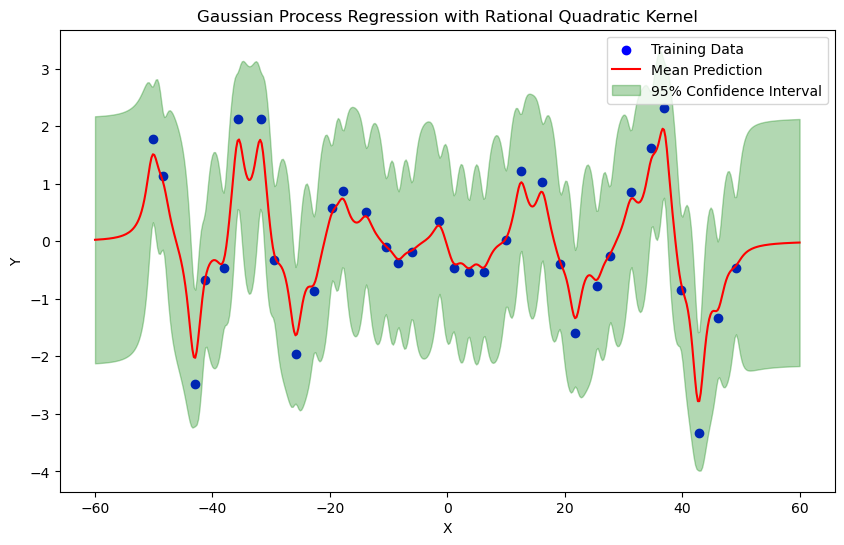

In [38]:
# hyperparameters
BETA = 5
ALPHA = 1
L_SCALE = 1
VAR = 1

visualize(X, Y, ALPHA, L_SCALE, VAR, BETA)